In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Load Data

In [426]:
dfolder = 'data/'

In [427]:
df = pd.read_csv(dfolder + 'merged.csv')

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_27626/446111836.py:1: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dfolder + 'merged.csv')


## Preprocessing

In [428]:
df = df[df['year'] >= 1989]

In [429]:
df['nonstate_deaths'].fillna(0, inplace=True)
df['onesided_deaths'].fillna(0, inplace=True)
df['civilian_deaths'].fillna(0, inplace=True)
df['deaths'].fillna(0, inplace=True)
df['state_deaths'].fillna(0, inplace=True)


In [430]:
# 'year' and 'month' columns to a datetime type
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# columns to be filled
fill_cols = [col for col in df.columns if 'count' in col]

dfs = []

# Iterate through unique 'isocode' values
for isocode in df['isocode'].unique():
    df_isocode = df[df['isocode'] == isocode].copy()

    # Create a new dataframe that covers all months between the min and max 'Date' for this isocode
    min_date = df_isocode['Date'].min()
    max_date = df_isocode['Date'].max()
    all_dates = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS'), columns=['Date'])

    # merge onto the existing dataframe
    df_isocode = pd.merge(all_dates, df_isocode, on='Date', how='left')

    df_isocode['isocode'] = isocode

    # forward-fill and then fill any remaining NaNs with 0
    df_isocode[fill_cols] = df_isocode[fill_cols].ffill().fillna(0)

    # convert the 'date' back to 'year' and 'month'
    df_isocode['year'] = df_isocode['Date'].dt.year
    df_isocode['month'] = df_isocode['Date'].dt.month

    # append to list
    dfs.append(df_isocode)

# concatenate all DataFrames in the list into a final DataFrame
df_final = pd.concat(dfs)

df_final.drop(columns=['Date'], inplace=True)

# sort final dataframe by 'isocode', 'year' and 'month'
df_final.sort_values(['year', 'month', 'isocode'], inplace=True)
df_final.fillna(0)


,MonthYear,isocode,month,year,count_events_1,count_events_2,count_events_3,count_events_4,count_events_5,count_events_6,...,count_events_17_opp,count_events_18_opp,count_events_19_opp,count_events_20_opp,country,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths
0,198901.0,AFG,1,1989,462.0,256.0,338.0,2024.0,264.0,88.0,...,0.0,14.0,76.0,0.0,Afghanistan,693.0,693.0,0.0,0.0,0.0
0,198901.0,AGO,1,1989,110.0,72.0,152.0,430.0,242.0,24.0,...,0.0,0.0,4.0,0.0,Angola,249.0,249.0,0.0,0.0,0.0
0,198901.0,ALB,1,1989,64.0,44.0,116.0,192.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,198901.0,ARE,1,1989,10.0,10.0,16.0,24.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
0,198901.0,ARG,1,1989,146.0,36.0,10.0,200.0,58.0,18.0,...,0.0,2.0,8.0,0.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,202305.0,XKX,5,2023,60.0,50.0,58.0,200.0,124.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,202305.0,YEM,5,2023,276.0,156.0,182.0,1364.0,362.0,38.0,...,2.0,2.0,4.0,0.0,Yemen,0.0,0.0,0.0,0.0,0.0
412,202305.0,ZAF,5,2023,6568.0,2976.0,2874.0,10818.0,3262.0,1188.0,...,6.0,2.0,12.0,0.0,South Africa,0.0,0.0,0.0,0.0,0.0
412,202305.0,ZMB,5,2023,386.0,264.0,176.0,724.0,374.0,48.0,...,0.0,0.0,0.0,0.0,Zambia,0.0,0.0,0.0,0.0,0.0


In [431]:
def get_country_name(iso_code):
    try:
        return pycountry.countries.get(alpha_3=iso_code).name
    except AttributeError:
        return None

df_final['country'] = df_final['isocode'].apply(get_country_name)

In [432]:
def check_month_year_sequence(group):
    # Create the expected sequence of months and years
    min_year, min_month = group[['year', 'month']].iloc[0] # use the first row of each group
    max_year, max_month = group[['year', 'month']].iloc[-1] # use the last row of each group

    expected_month_years = [(y, m) for y in range(min_year, max_year + 1) for m in range(1, 13)]
    
    # If there is only one year in the data, filter for months within the min and max range
    if min_year == max_year:
        expected_month_years = [my for my in expected_month_years if min_month <= my[1] <= max_month]
    else:
        # If there are multiple years, adjust for the first and last years
        expected_month_years = [my for my in expected_month_years if 
                                not (my[0] == min_year and my[1] < min_month) and 
                                not (my[0] == max_year and my[1] > max_month)]
                                
    # Check if the sequence of month-years in the group is equal to the expected sequence
    actual_month_years = sorted(list(zip(group['year'], group['month'])))
    
    if actual_month_years != expected_month_years:
        print(f"Incorrect sequence for isocode: {group['isocode'].iloc[0]}")
        print(f"Expected: {expected_month_years}")
        print(f"Actual: {actual_month_years}")
        
    return actual_month_years == expected_month_years


In [433]:
# Apply the function to each group
is_sequence_correct = df_final.groupby('isocode').apply(check_month_year_sequence)

# Check if the sequence of month-years is correct for all isocodes
assert is_sequence_correct.all(), "The sequence of month-years is not correct for some isocodes"

In [434]:
df_final['date'] = pd.to_datetime(df_final[['year', 'month']].assign(day=1))

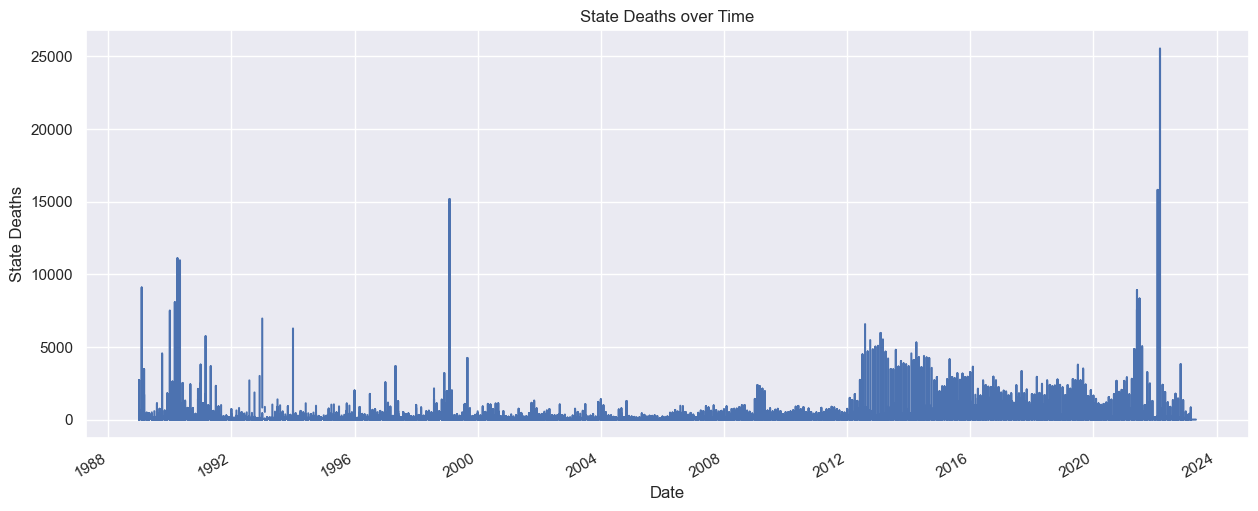

In [435]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
df_final.set_index('date')['state_deaths'].plot()
plt.title('State Deaths over Time')
plt.xlabel('Date')
plt.ylabel('State Deaths')
plt.show()


In [436]:
df_final = df_final.sort_values(['year', 'month', 'isocode'])


In [437]:
# List of all event count columns for gov, opp and total events
event_cols = ['count_events_{}'.format(i) for i in range(1, 21)]
event_cols_gov = ['count_events_{}_gov'.format(i) for i in range(1, 21)]
event_cols_opp = ['count_events_{}_opp'.format(i) for i in range(1, 21)]

# Compute the total events for each group
df_final['total_events'] = df_final[event_cols].sum(axis=1)
df_final['total_events_gov'] = df_final[event_cols_gov].sum(axis=1)
df_final['total_events_opp'] = df_final[event_cols_opp].sum(axis=1)

# Compute the share of each type of event for each group and create new columns
for col in event_cols:
    df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events']
    
for col in event_cols_gov:
    df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events_gov']

for col in event_cols_opp:
    df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events_opp']

# Drop the original count_events_* columns
df_final.drop(columns=event_cols + event_cols_gov + event_cols_opp, inplace=True)
df_final = df_final.fillna(0)



In [438]:
# columns to drop
cols_to_drop = ['total_events', 'total_events_gov', 'total_events_opp',
                'nonstate_deaths', 'onesided_deaths', 'civilian_deaths', 'state_deaths', 'MonthYear', 'date', 'country']

# Drop the columns
df_final = df_final.drop(columns=cols_to_drop, axis=1)


In [439]:
df_final# Define conflict column
df_final['conflict'] = df_final['deaths'].apply(lambda x: 1 if x > 100 else 0)

# Drop rows with missing values
df_final = df_final.dropna()

In [440]:
def get_country_name(iso_code):
    try:
        return pycountry.countries.get(alpha_3=iso_code).name
    except AttributeError:
        return None

df_final['country'] = df_final['isocode'].apply(get_country_name)

In [441]:
df_final.reset_index(drop=True, inplace=True)

### Normalizing

In [442]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_final.drop(columns=['isocode','month','year','conflict','country']))

In [443]:
scaled_df=pd.DataFrame(data=scaled,columns=df_final.drop(columns=['isocode','month','year','conflict','country']).columns)


In [444]:
scaled_df

,deaths,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,share_events_count_events_6,share_events_count_events_7,share_events_count_events_8,share_events_count_events_9,...,share_events_count_events_11_opp,share_events_count_events_12_opp,share_events_count_events_13_opp,share_events_count_events_14_opp,share_events_count_events_15_opp,share_events_count_events_16_opp,share_events_count_events_17_opp,share_events_count_events_18_opp,share_events_count_events_19_opp,share_events_count_events_20_opp
0,0.001327,0.079903,0.044275,0.058457,0.350052,0.045659,0.015220,0.023175,0.068834,0.006226,...,0.043269,0.096154,0.009615,0.000000,0.0,0.009615,0.000000,0.033654,0.182692,0.0
1,0.000477,0.074124,0.048518,0.102426,0.289757,0.163073,0.016173,0.030997,0.079515,0.024259,...,0.000000,0.000000,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.0
2,0.000000,0.123077,0.084615,0.223077,0.369231,0.034615,0.000000,0.011538,0.003846,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.116279,0.116279,0.186047,0.279070,0.023256,0.023256,0.000000,0.093023,0.046512,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.139847,0.034483,0.009579,0.191571,0.055556,0.017241,0.019157,0.032567,0.047893,...,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.200000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97833,0.000000,0.092308,0.076923,0.089231,0.307692,0.190769,0.003077,0.018462,0.012308,0.018462,...,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0
97834,0.000000,0.082192,0.046456,0.054199,0.406194,0.107802,0.011316,0.030375,0.055390,0.008338,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.021277,0.021277,0.042553,0.0
97835,0.000000,0.151882,0.068819,0.066460,0.250162,0.075432,0.027472,0.036306,0.030478,0.024235,...,0.086614,0.047244,0.015748,0.062992,0.0,0.000000,0.023622,0.007874,0.047244,0.0
97836,0.000000,0.146992,0.100533,0.067022,0.275704,0.142422,0.018279,0.048743,0.019040,0.020564,...,0.500000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [445]:
conf=df_final.copy()
conf[scaled_df.columns]=np.array(scaled_df)
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','month','year'])
conf

,,,deaths,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,share_events_count_events_6,share_events_count_events_7,share_events_count_events_8,share_events_count_events_9,...,share_events_count_events_13_opp,share_events_count_events_14_opp,share_events_count_events_15_opp,share_events_count_events_16_opp,share_events_count_events_17_opp,share_events_count_events_18_opp,share_events_count_events_19_opp,share_events_count_events_20_opp,conflict,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,1989,0.001327,0.079903,0.044275,0.058457,0.350052,0.045659,0.015220,0.023175,0.068834,0.006226,...,0.009615,0.000000,0.0,0.009615,0.000000,0.033654,0.182692,0.0,1,Afghanistan
AGO,1,1989,0.000477,0.074124,0.048518,0.102426,0.289757,0.163073,0.016173,0.030997,0.079515,0.024259,...,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.0,1,Angola
ALB,1,1989,0.000000,0.123077,0.084615,0.223077,0.369231,0.034615,0.000000,0.011538,0.003846,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,Albania
ARE,1,1989,0.000000,0.116279,0.116279,0.186047,0.279070,0.023256,0.023256,0.000000,0.093023,0.046512,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,United Arab Emirates
ARG,1,1989,0.000000,0.139847,0.034483,0.009579,0.191571,0.055556,0.017241,0.019157,0.032567,0.047893,...,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.200000,0.0,0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.092308,0.076923,0.089231,0.307692,0.190769,0.003077,0.018462,0.012308,0.018462,...,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0,None
YEM,5,2023,0.000000,0.082192,0.046456,0.054199,0.406194,0.107802,0.011316,0.030375,0.055390,0.008338,...,0.000000,0.000000,0.0,0.000000,0.021277,0.021277,0.042553,0.0,0,Yemen
ZAF,5,2023,0.000000,0.151882,0.068819,0.066460,0.250162,0.075432,0.027472,0.036306,0.030478,0.024235,...,0.015748,0.062992,0.0,0.000000,0.023622,0.007874,0.047244,0.0,0,South Africa


In [446]:
top_10_countries=pd.DataFrame(conf.groupby('country')['conflict'].sum()).sort_values(by='conflict',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

### Train Test Split

In [447]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['conflict']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['conflict']).iloc[size:]
    y_train=data['conflict'].iloc[0:size] 
    y_test=data['conflict'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [448]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [449]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [450]:
# double check the train data and test data and our target 
X_train.head(2)

deaths  share_events_count_events_1  \
isocode month year                                        
NRU     1     1989     0.0                     0.333333   
        2     1989     0.0                     0.333333   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
NRU     1     1989                     0.333333                          0.0   
        2     1989                     0.333333                          0.0   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
NRU     1     1989                          0.0                     0.166667   
        2     1989                          0.0                     0.166667   

                    share_events_count_events_6  share_events_count_events_7  \
isocode month year                                                             
NRU     1     1989                          0.0                          0.0   
        2     1989                          0.0                          0.0   

                    share_events_count_events_8  share_events_count_events_9  \
isocode month year                                                             
NRU     1     1989                          0.0                          0.0   
        2     1989                          0.0                          0.0   

                    ...  share_events_count_events_12_opp  \
isocode month year  ...                                     
NRU     1     1989  ...                               0.0   
        2     1989  ...                               0.0   

                    share_events_count_events_13_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_14_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_15_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_16_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_17_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_18_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_19_opp  \
isocode month year                                     
NRU     1     1989                               0.0   
        2     1989                               0.0   

                    share_events_count_events_20_opp  country  
isocode month year                                             
NRU     1     1989                               0.0    Nauru  
        2     1989                               0.0    Nauru  

[2 rows x 62 columns]

## Model

In [451]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [452]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(19581, 63)

In [453]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

In [454]:
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Output layer
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False)

Epoch 1/30


2023-06-19 14:43:57.999729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1557/1557 [==============================] - 23s 14ms/step - loss: 0.2371 - accuracy: 0.9619
Epoch 2/30
1557/1557 [==============================] - 22s 14ms/step - loss: 0.1857 - accuracy: 0.9655
Epoch 3/30
1557/1557 [==============================] - 20s 13ms/step - loss: 0.1809 - accuracy: 0.9637
Epoch 4/30
1557/1557 [==============================] - 20s 13ms/step - loss: 0.1360 - accuracy: 0.9668
Epoch 5/30
1557/1557 [==============================] - 21s 13ms/step - loss: 0.1490 - accuracy: 0.9684
Epoch 6/30
1557/1557 [==============================] - 20s 13ms/step - loss: 0.1401 - accuracy: 0.9705
Epoch 7/30
1557/1557 [==============================] - 21s 13ms/step - loss: 0.1387 - accuracy: 0.9703
Epoch 8/30
1557/1557 [==============================] - 20s 13ms/step - loss: 0.1408 - accuracy: 0.9700
Epoch 9/30
1557/1557 [==============================] - 20s 13ms/step - loss: 0.1232 - accuracy: 0.9705
Epoch 10/30
1557/1557 [==============================] - 21s 14ms/step - lo

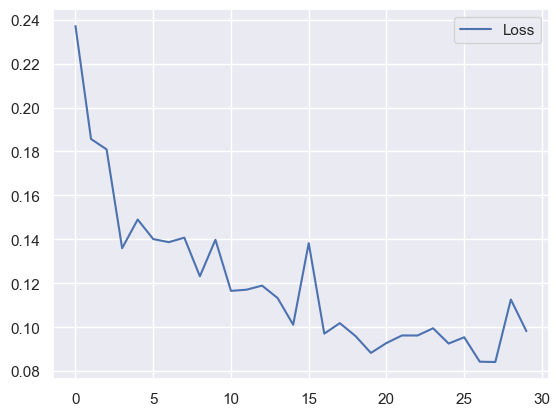

In [455]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [456]:
y_hat = model.predict(x_test)

  4/612 [..............................] - ETA: 12s 

2023-06-19 14:54:37.525223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


612/612 [==============================] - 3s 5ms/step


In [457]:
y_hat.shape,y_test.shape


((19580, 1), (19580,))

In [458]:
# a little tricky thing is y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(19579, 19579)

In [459]:
pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[1:-1]
pa['Year'] = X_test.reset_index().year.iloc[1:-1]
pa['Prediction'] = [i[0] for i in y_hat][1:] 
pa['Actual Values'] = y_test[:-1]
pa.head()


,Month,Year,Prediction,Actual Values
1,8,2016,0.001176,0.0
2,9,2016,0.001924,0.0
3,10,2016,0.002210,0.0
4,11,2016,0.000992,0.0
5,12,2016,0.000345,0.0


In [460]:
pa['Actual Values'].sum()

798.0

## Interpretation

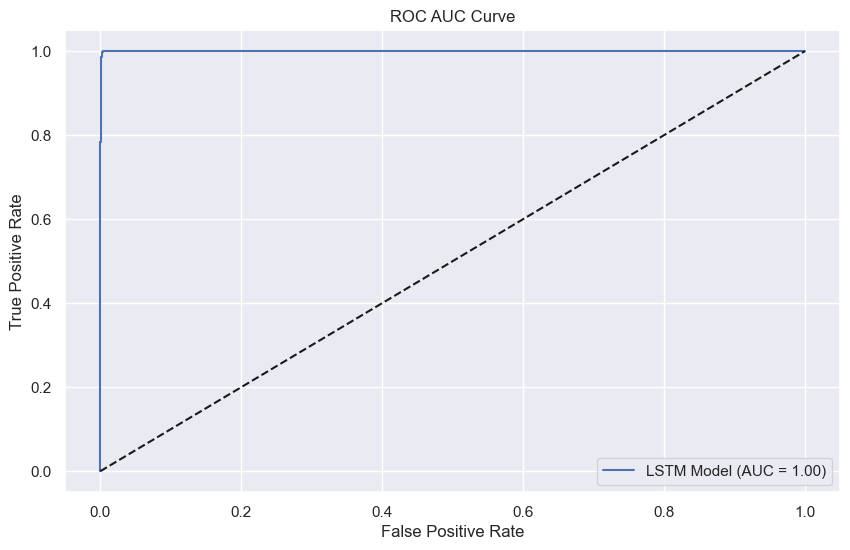

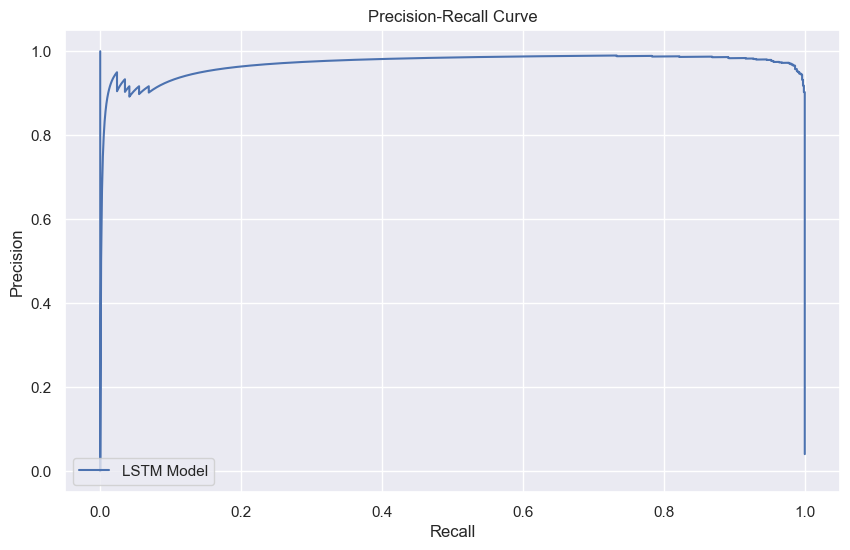

In [461]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [462]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (y_hat > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

roc_auc_minority = roc_auc_score(y_test == 1, y_hat)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[18583   199]
 [  268   530]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18782
         1.0       0.73      0.66      0.69       798

    accuracy                           0.98     19580
   macro avg       0.86      0.83      0.84     19580
weighted avg       0.98      0.98      0.98     19580


ROC AUC for minority class: 0.971639179409497


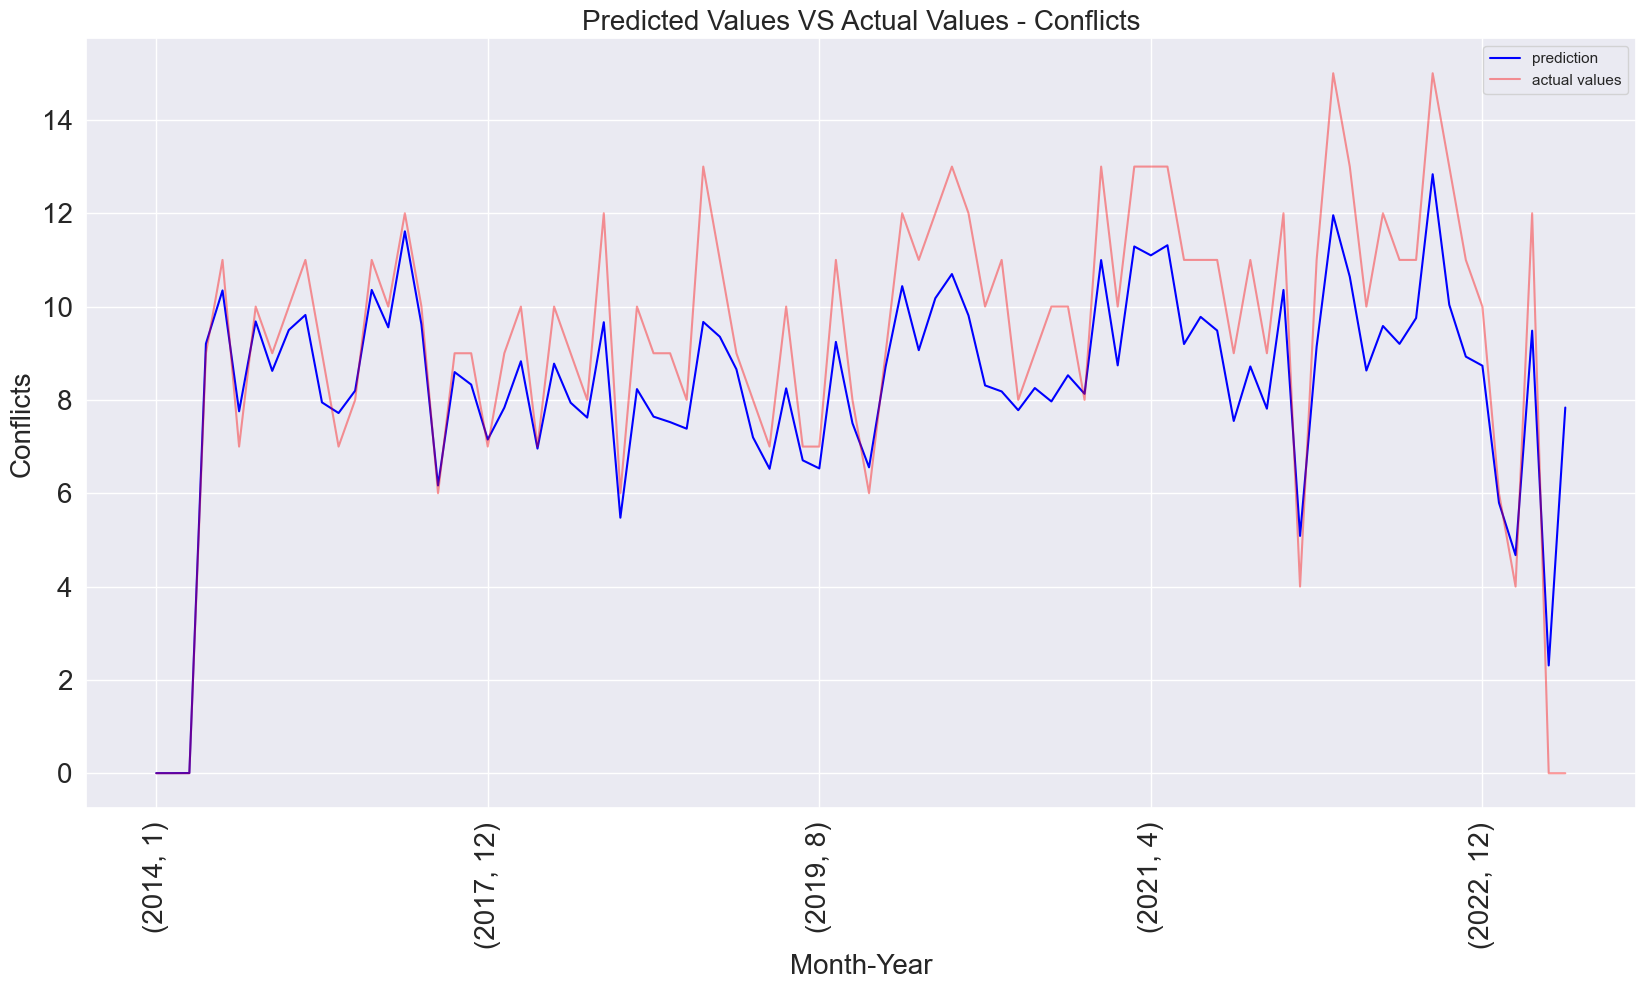

In [463]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [464]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [465]:
print(RMSE(y_test[:-1],[i[0] for i in y_hat][1:]))

0.06975873590936768


In [474]:
conf

,,,deaths,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,share_events_count_events_6,share_events_count_events_7,share_events_count_events_8,share_events_count_events_9,...,share_events_count_events_13_opp,share_events_count_events_14_opp,share_events_count_events_15_opp,share_events_count_events_16_opp,share_events_count_events_17_opp,share_events_count_events_18_opp,share_events_count_events_19_opp,share_events_count_events_20_opp,conflict,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,1989,0.001327,0.079903,0.044275,0.058457,0.350052,0.045659,0.015220,0.023175,0.068834,0.006226,...,0.009615,0.000000,0.0,0.009615,0.000000,0.033654,0.182692,0.0,1,Afghanistan
AGO,1,1989,0.000477,0.074124,0.048518,0.102426,0.289757,0.163073,0.016173,0.030997,0.079515,0.024259,...,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.0,1,Angola
ALB,1,1989,0.000000,0.123077,0.084615,0.223077,0.369231,0.034615,0.000000,0.011538,0.003846,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,Albania
ARE,1,1989,0.000000,0.116279,0.116279,0.186047,0.279070,0.023256,0.023256,0.000000,0.093023,0.046512,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,United Arab Emirates
ARG,1,1989,0.000000,0.139847,0.034483,0.009579,0.191571,0.055556,0.017241,0.019157,0.032567,0.047893,...,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.200000,0.0,0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.092308,0.076923,0.089231,0.307692,0.190769,0.003077,0.018462,0.012308,0.018462,...,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0,None
YEM,5,2023,0.000000,0.082192,0.046456,0.054199,0.406194,0.107802,0.011316,0.030375,0.055390,0.008338,...,0.000000,0.000000,0.0,0.000000,0.021277,0.021277,0.042553,0.0,0,Yemen
ZAF,5,2023,0.000000,0.151882,0.068819,0.066460,0.250162,0.075432,0.027472,0.036306,0.030478,0.024235,...,0.015748,0.062992,0.0,0.000000,0.023622,0.007874,0.047244,0.0,0,South Africa


In [476]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['isocode','month','year','conflict','country']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['isocode','month','year','conflict','country']).columns)
    scaled_df['conflict']=list(country.conflict)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['conflict']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['conflict']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

2023-06-19 15:05:47.309125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 33ms/step


2023-06-19 15:05:51.351593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Afghanistan - RMSE: 0.2939723678960656


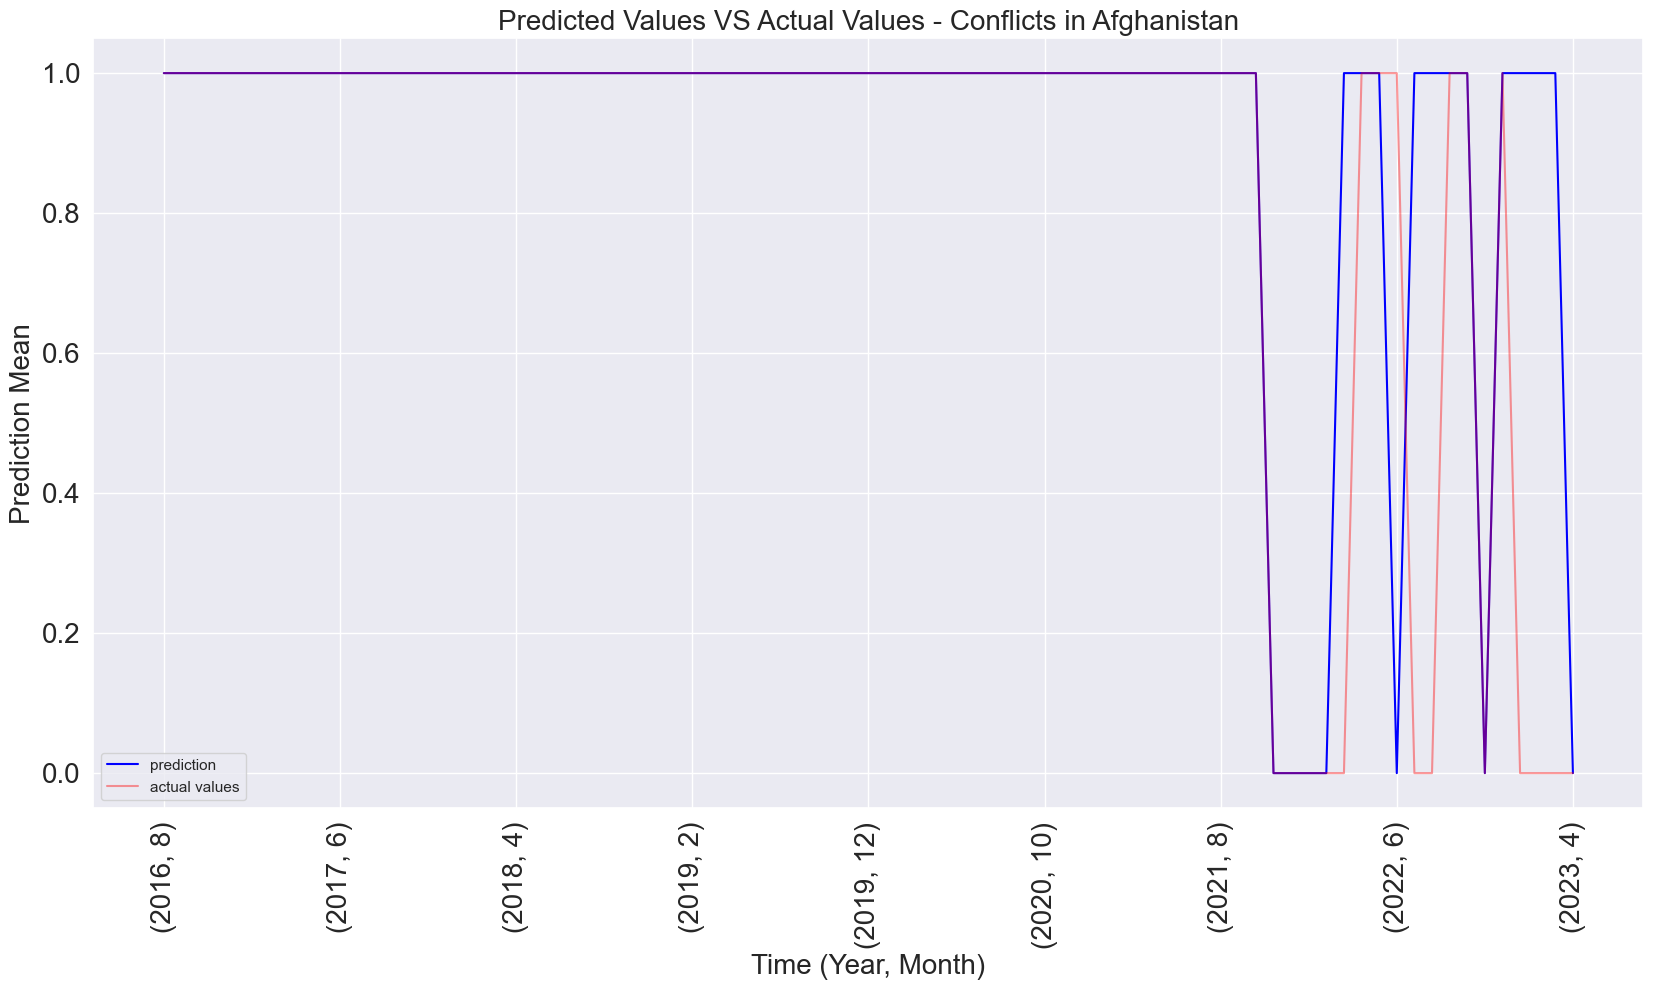

2023-06-19 15:05:52.020335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 31ms/step


2023-06-19 15:05:55.991030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


India - RMSE: 0.19245008972987526


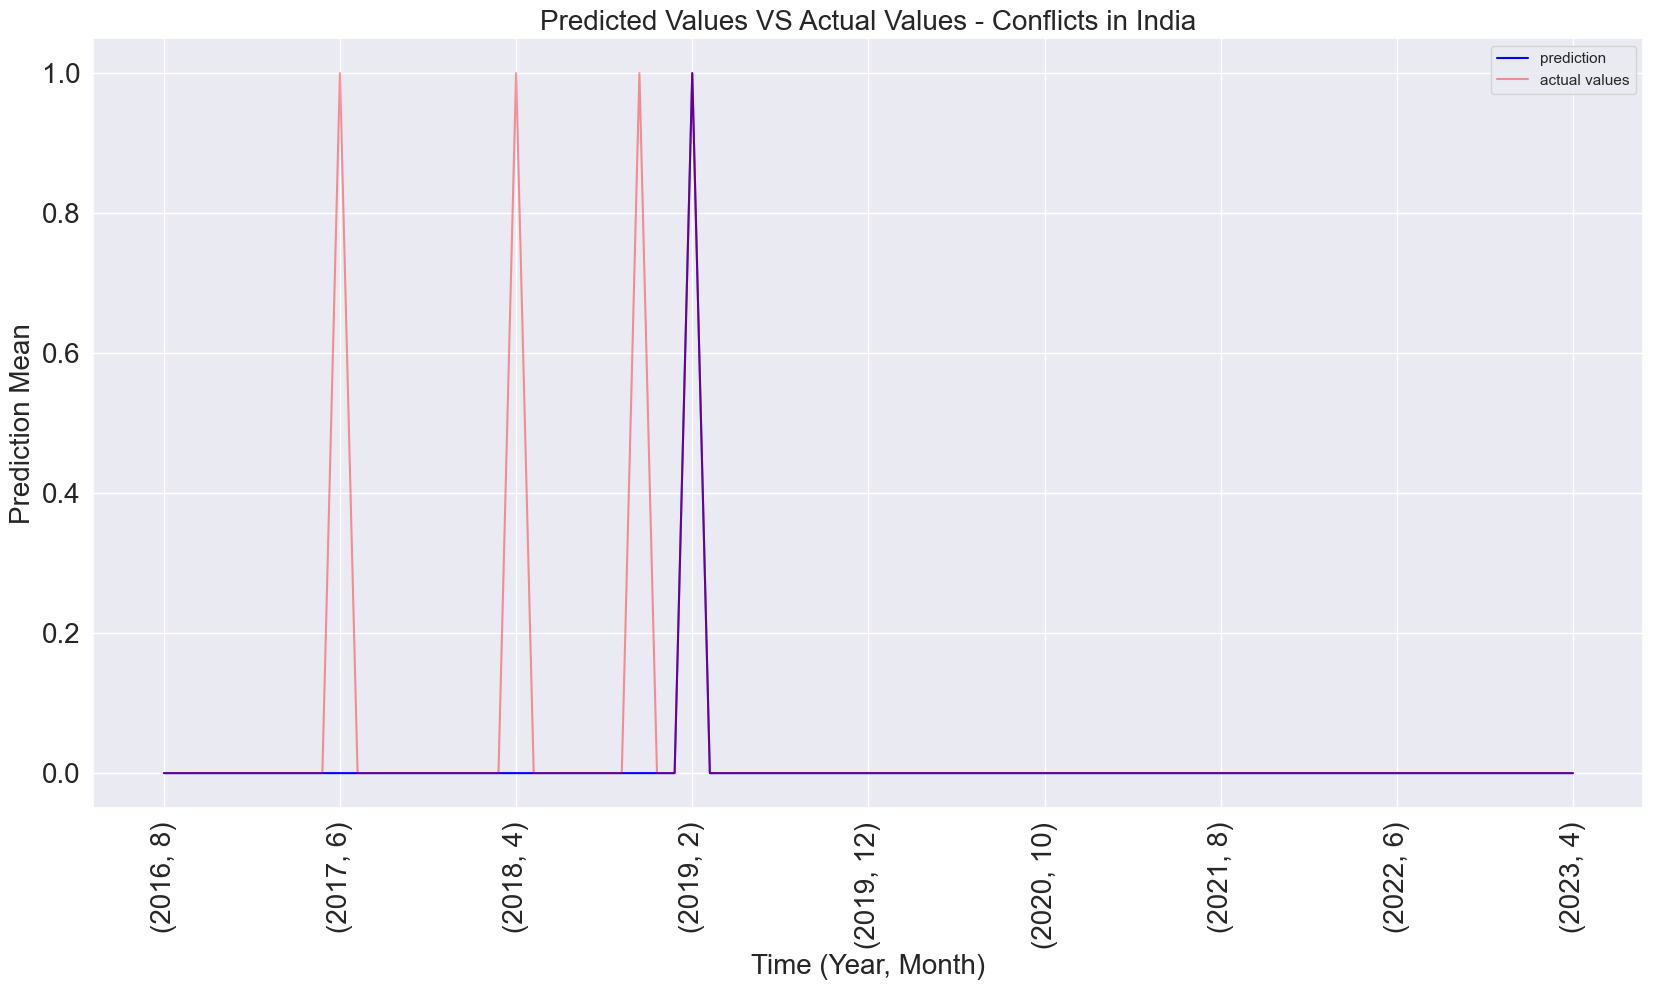

2023-06-19 15:05:56.631958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 33ms/step


2023-06-19 15:06:00.681320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sudan - RMSE: 0.41573970964154905


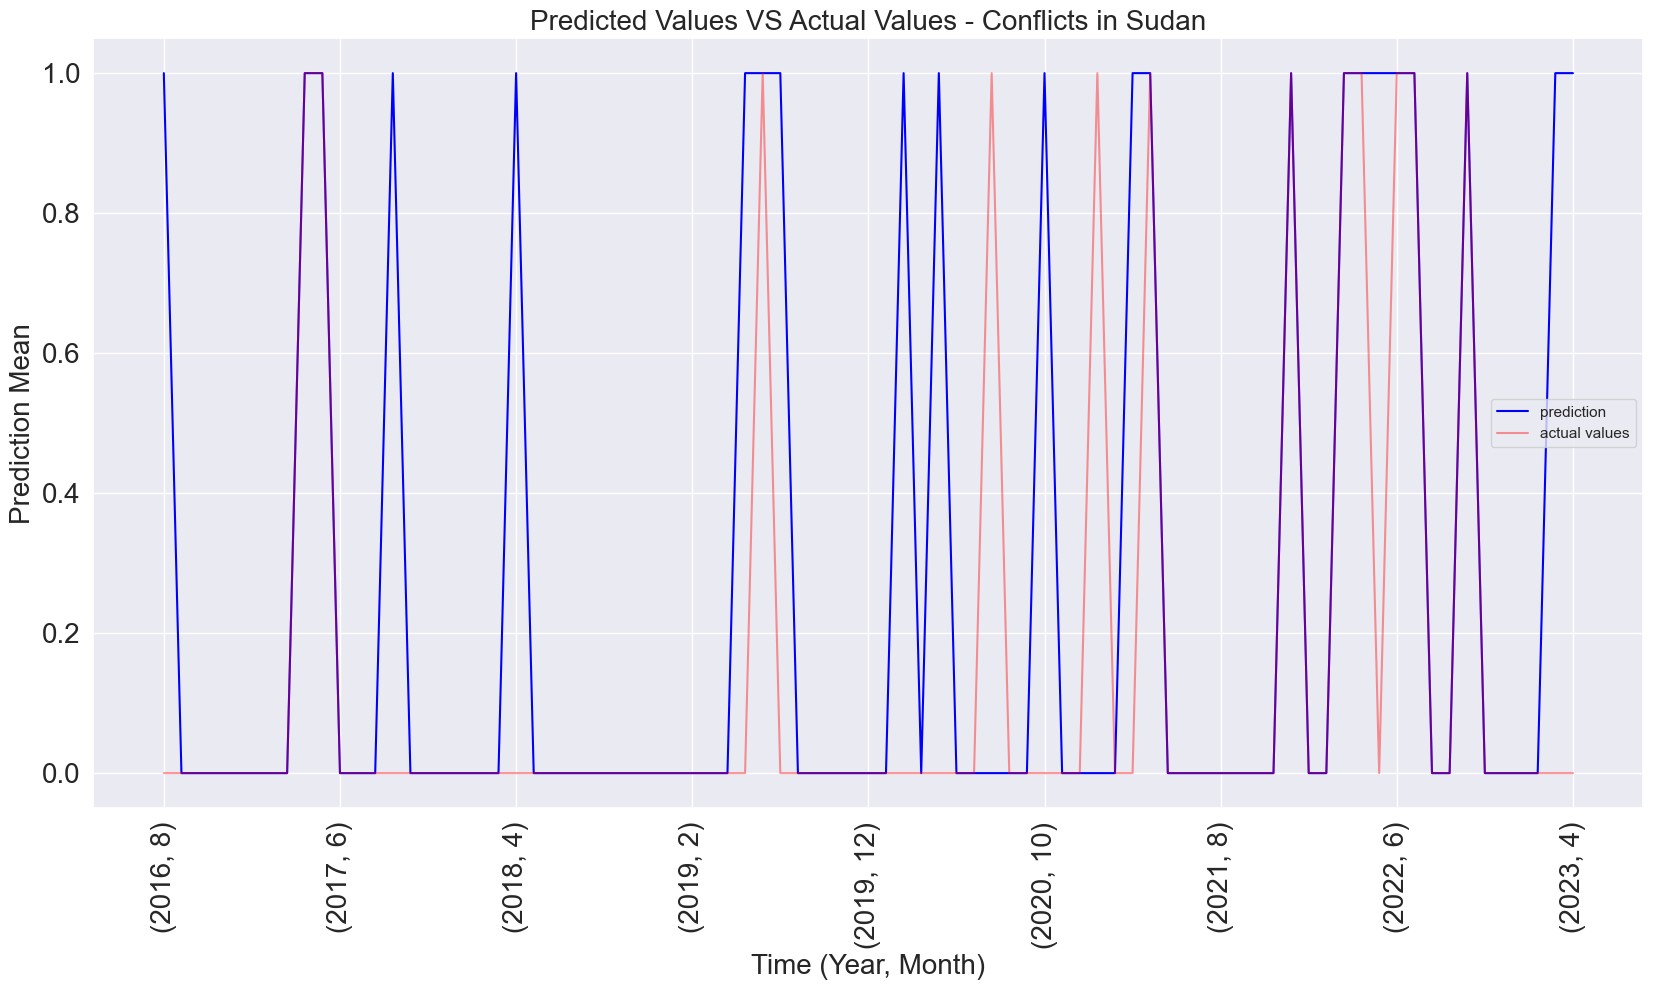

2023-06-19 15:06:03.504605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 34ms/step


2023-06-19 15:06:08.026624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Congo, The Democratic Republic of the - RMSE: 0.5555555555555556


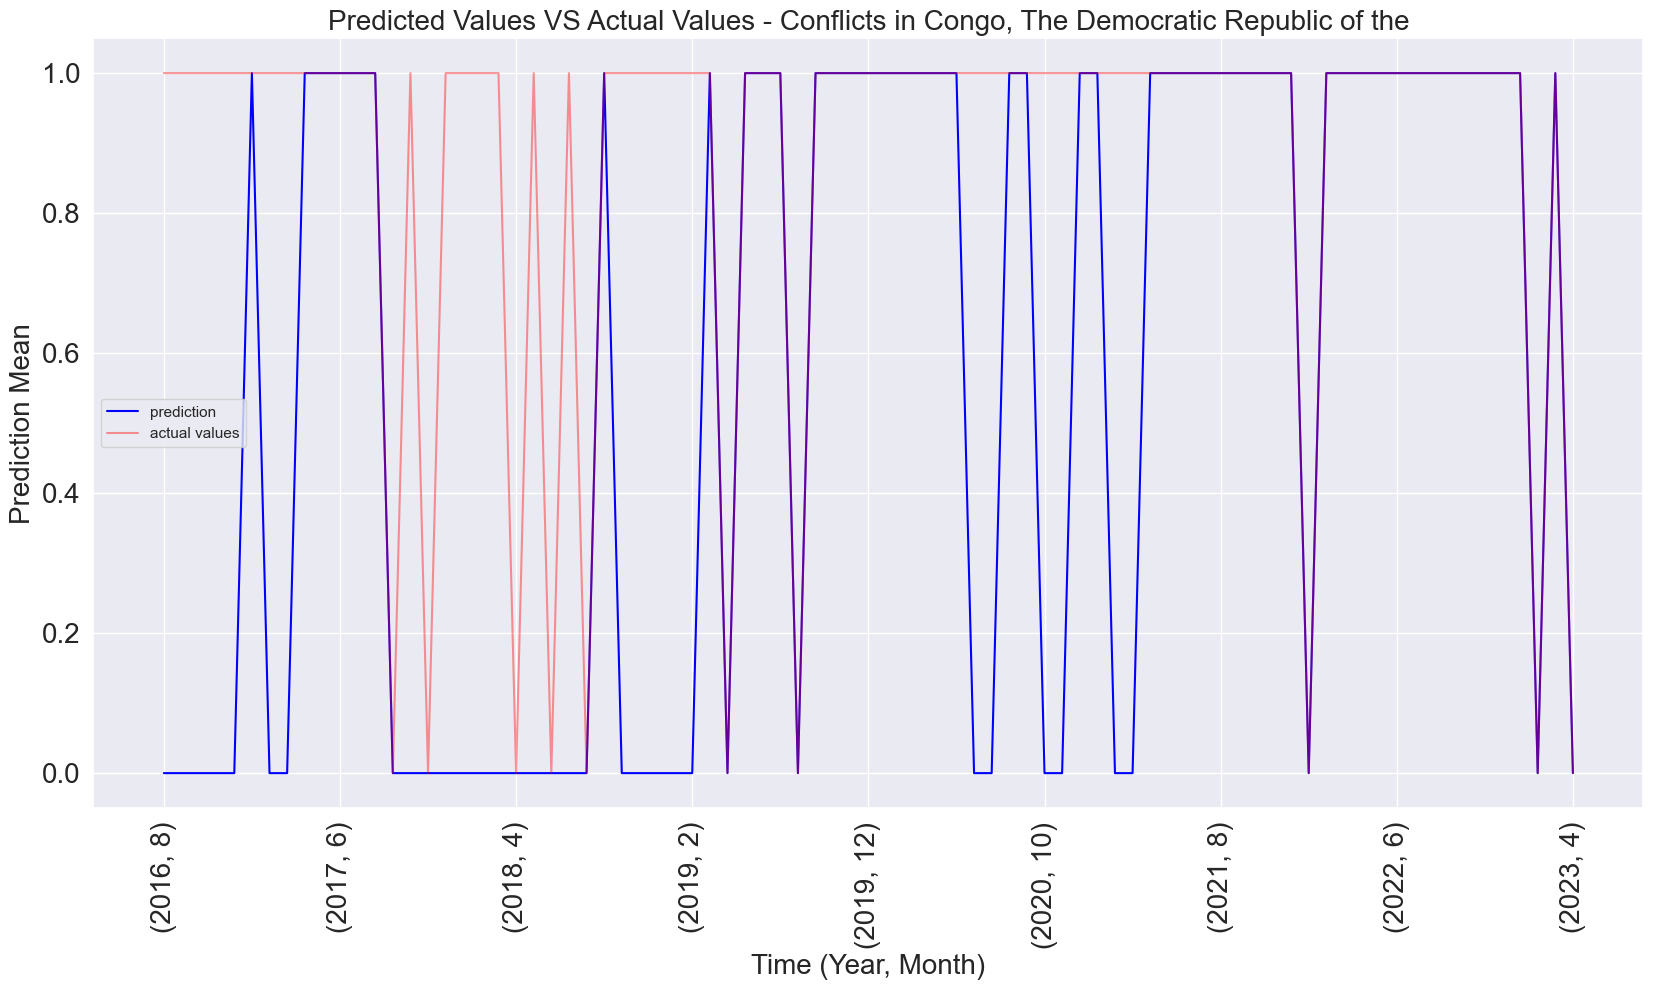

2023-06-19 15:06:08.759571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 38ms/step


2023-06-19 15:06:13.007265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Somalia - RMSE: 0.3849001794597505


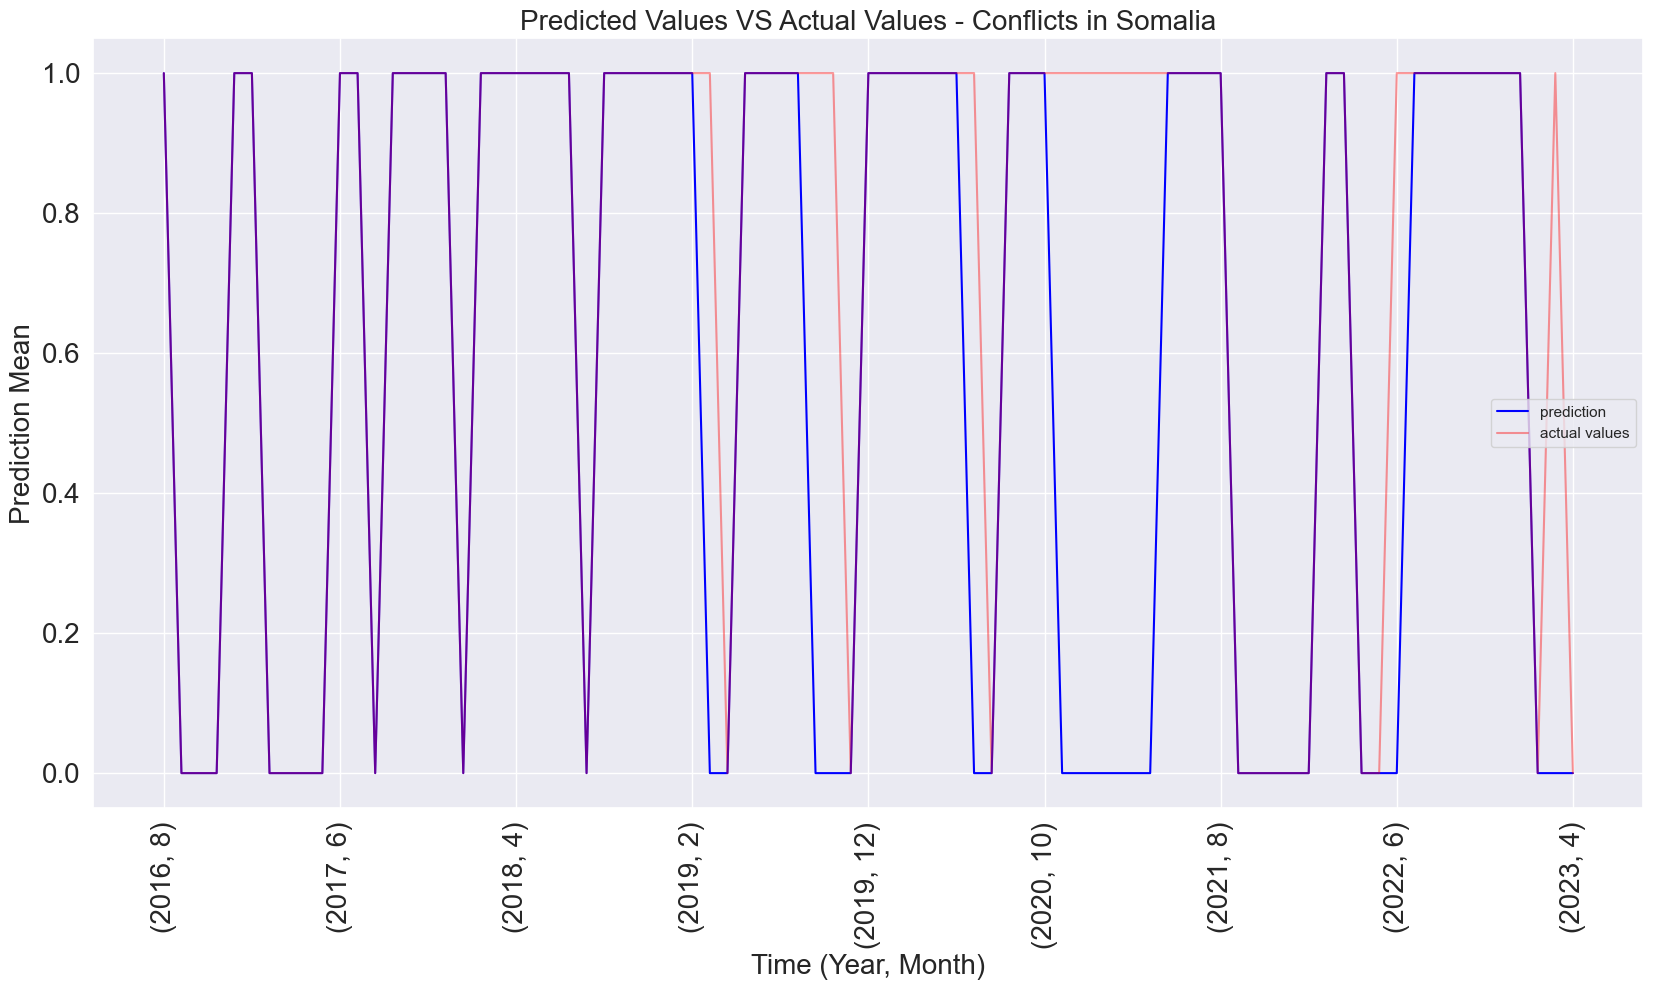

2023-06-19 15:06:13.910575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 45ms/step


2023-06-19 15:06:18.061646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iraq - RMSE: 0.5555555555555556


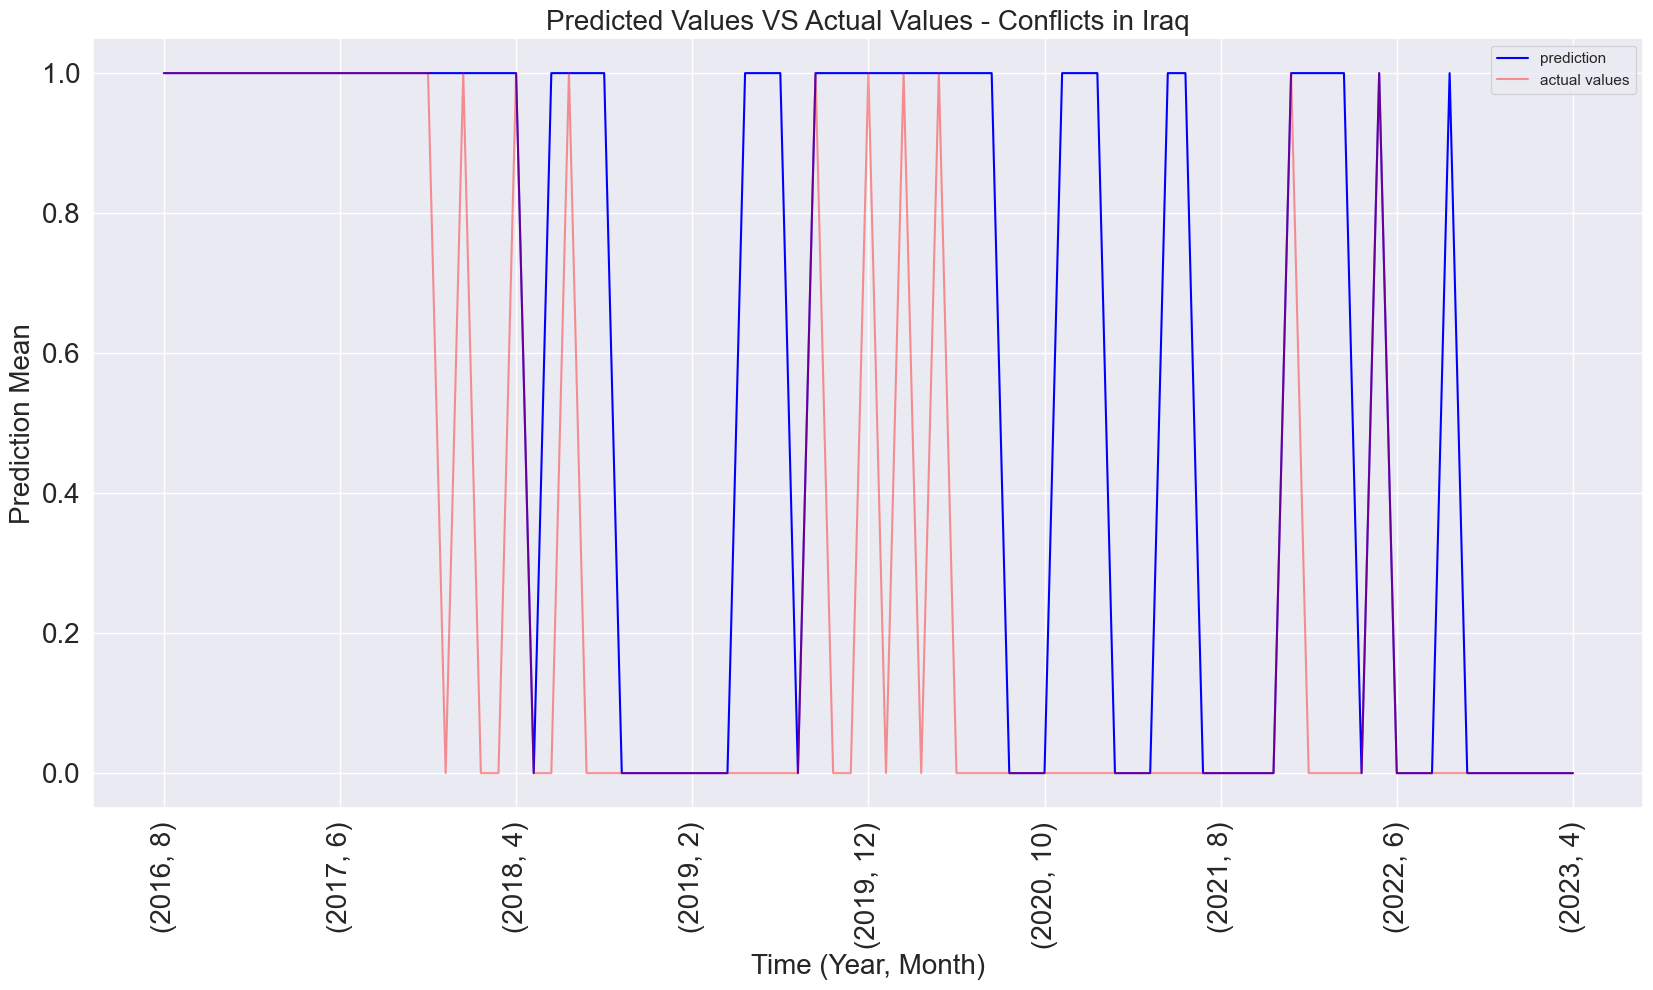

2023-06-19 15:06:18.760036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 38ms/step


2023-06-19 15:06:22.947863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Nigeria - RMSE: 0.7856742013183862


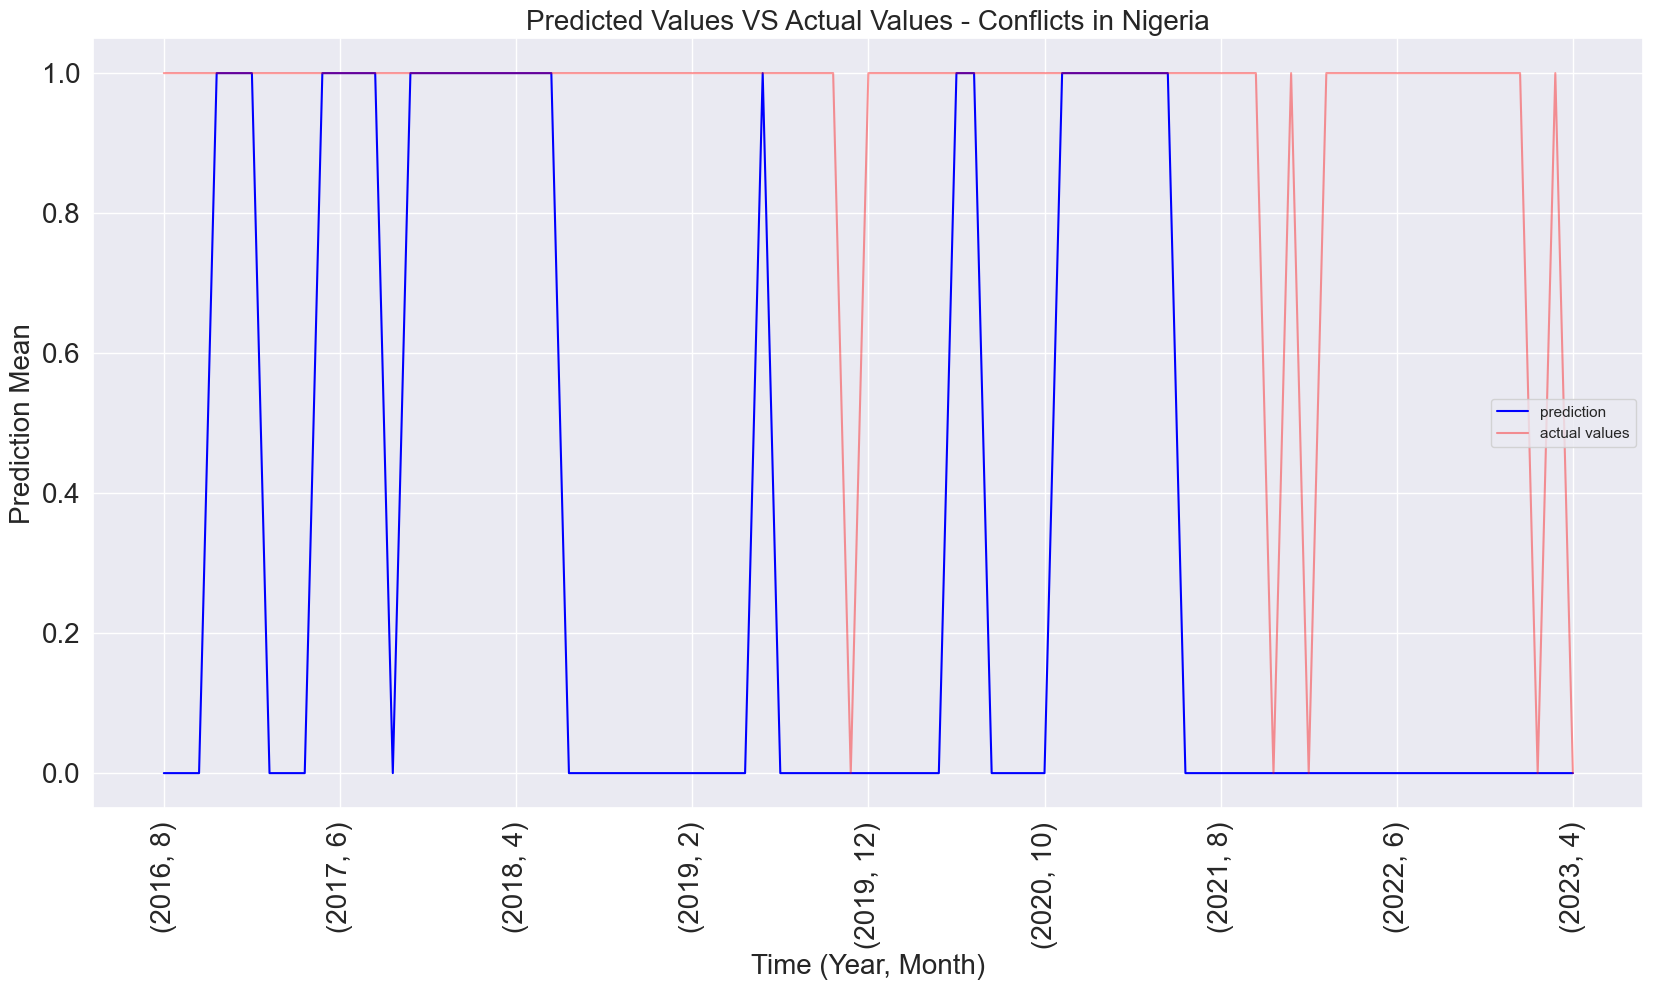

2023-06-19 15:06:23.655699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2023-06-19 15:06:27.878660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 177ms/step
Syrian Arab Republic - RMSE: 0.31426968052735443


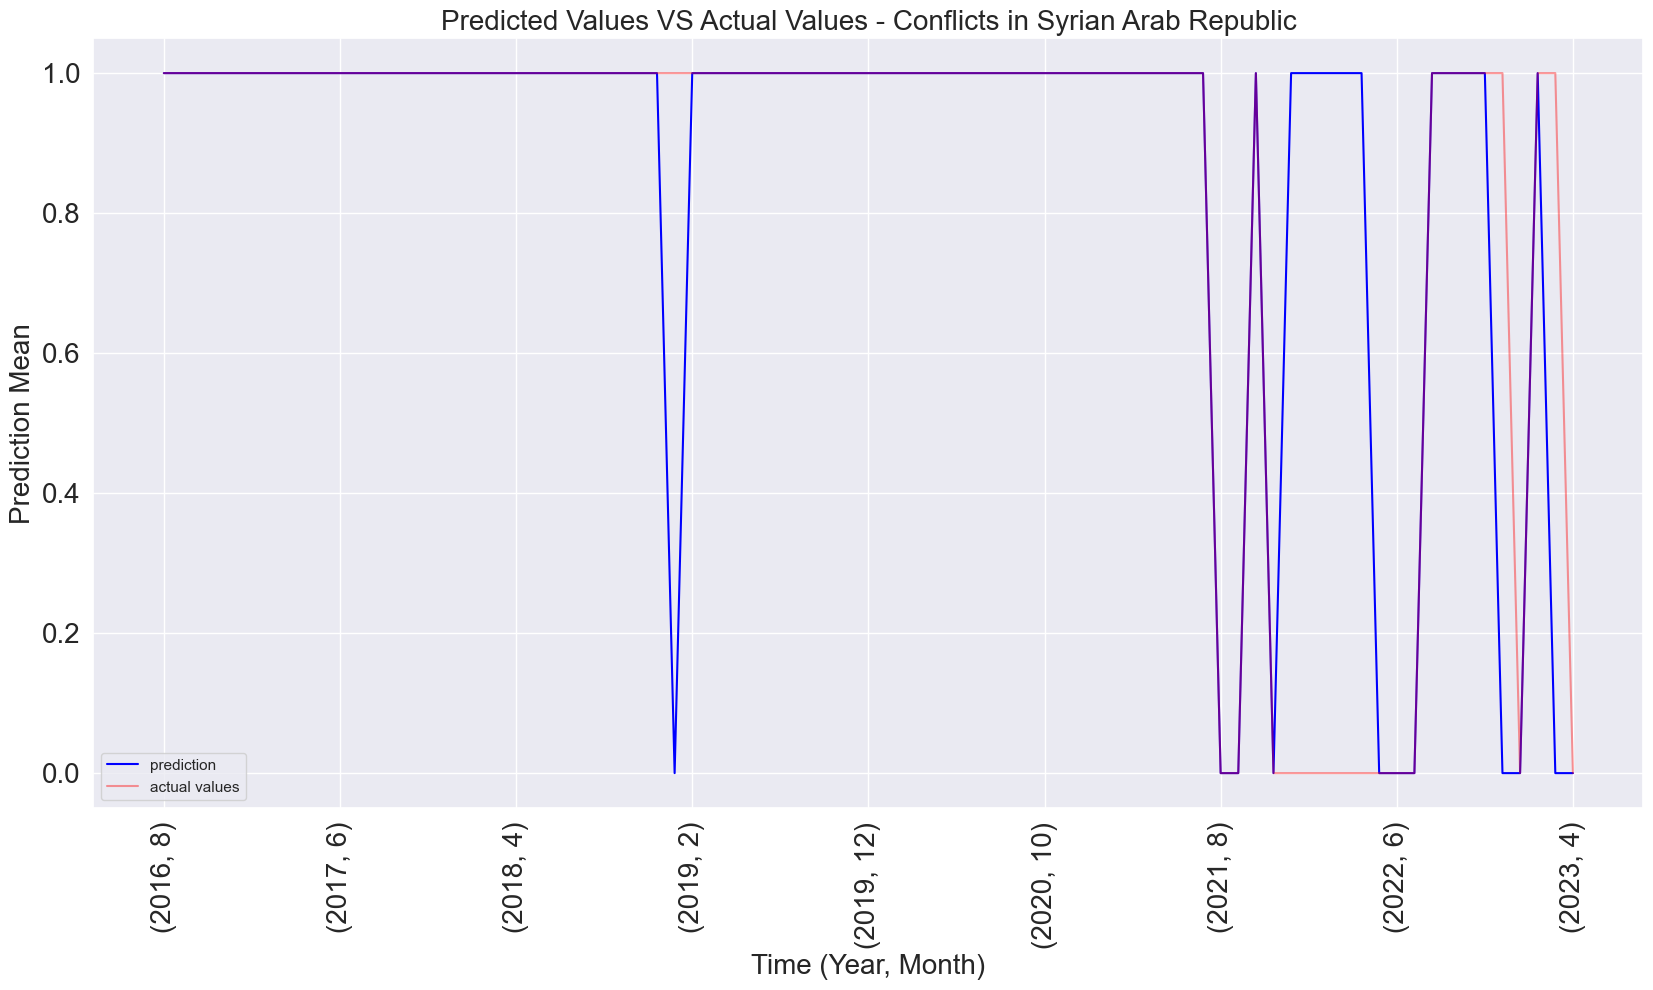

2023-06-19 15:06:28.874522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2023-06-19 15:06:33.449733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 75ms/step
Sri Lanka - RMSE: 0.1111111111111111


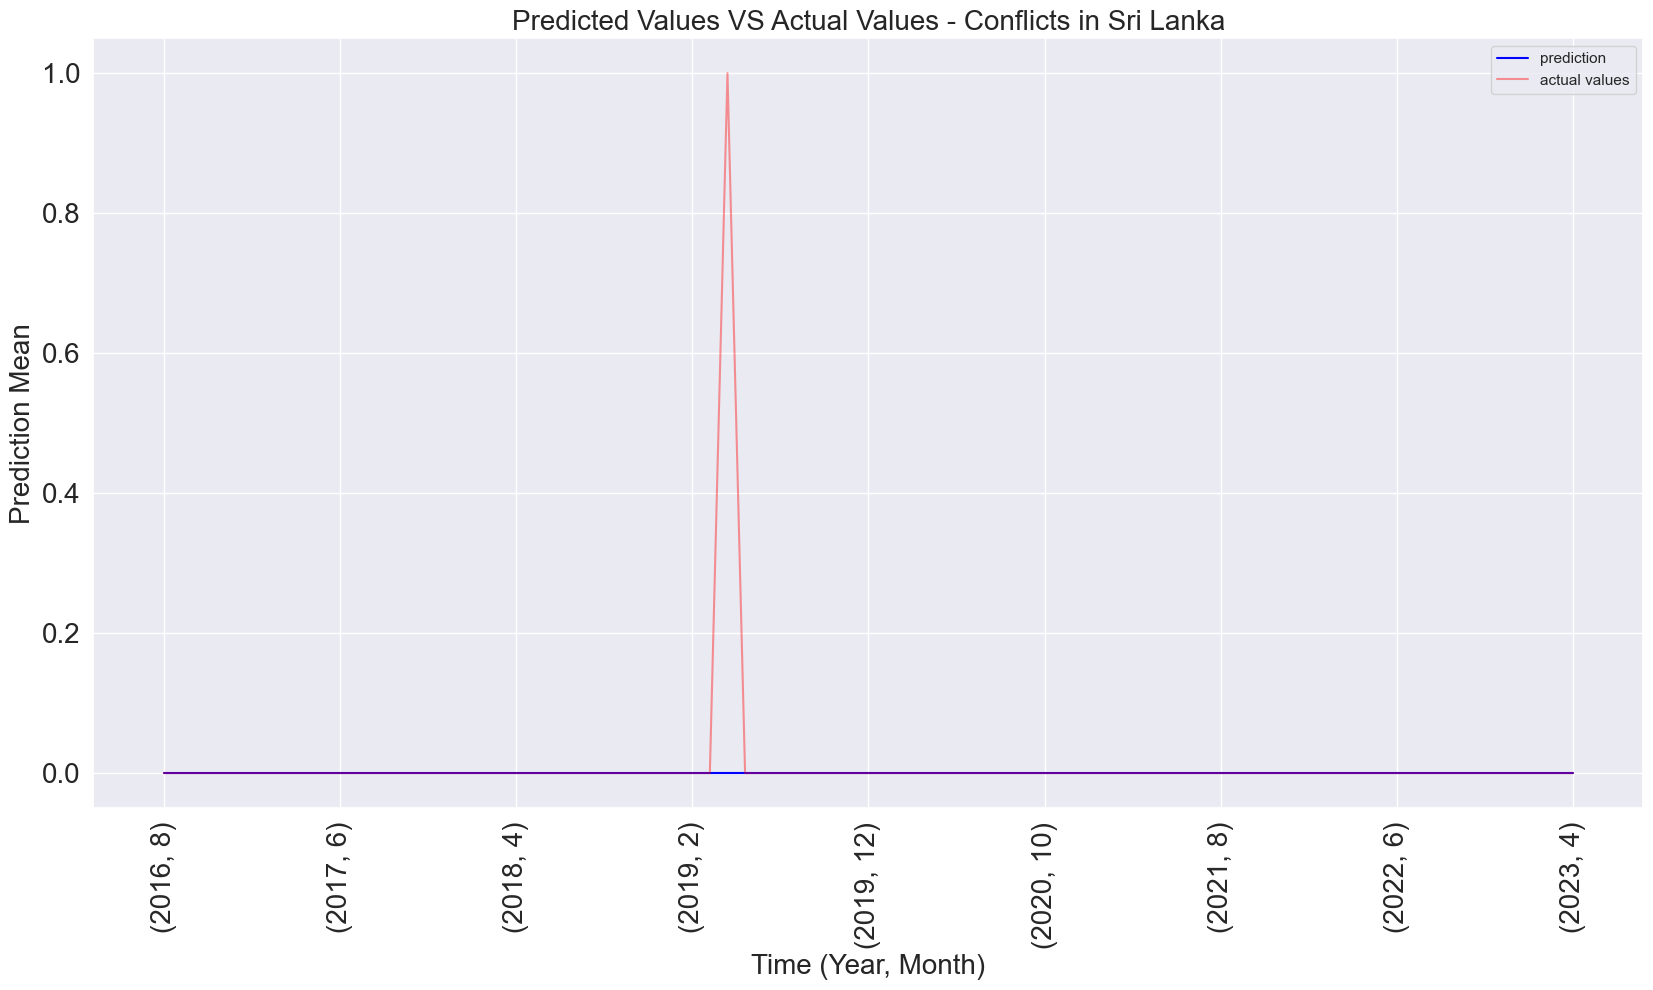

2023-06-19 15:06:34.408628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 33ms/step


2023-06-19 15:06:38.884754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Mexico - RMSE: 0.8678055195451838


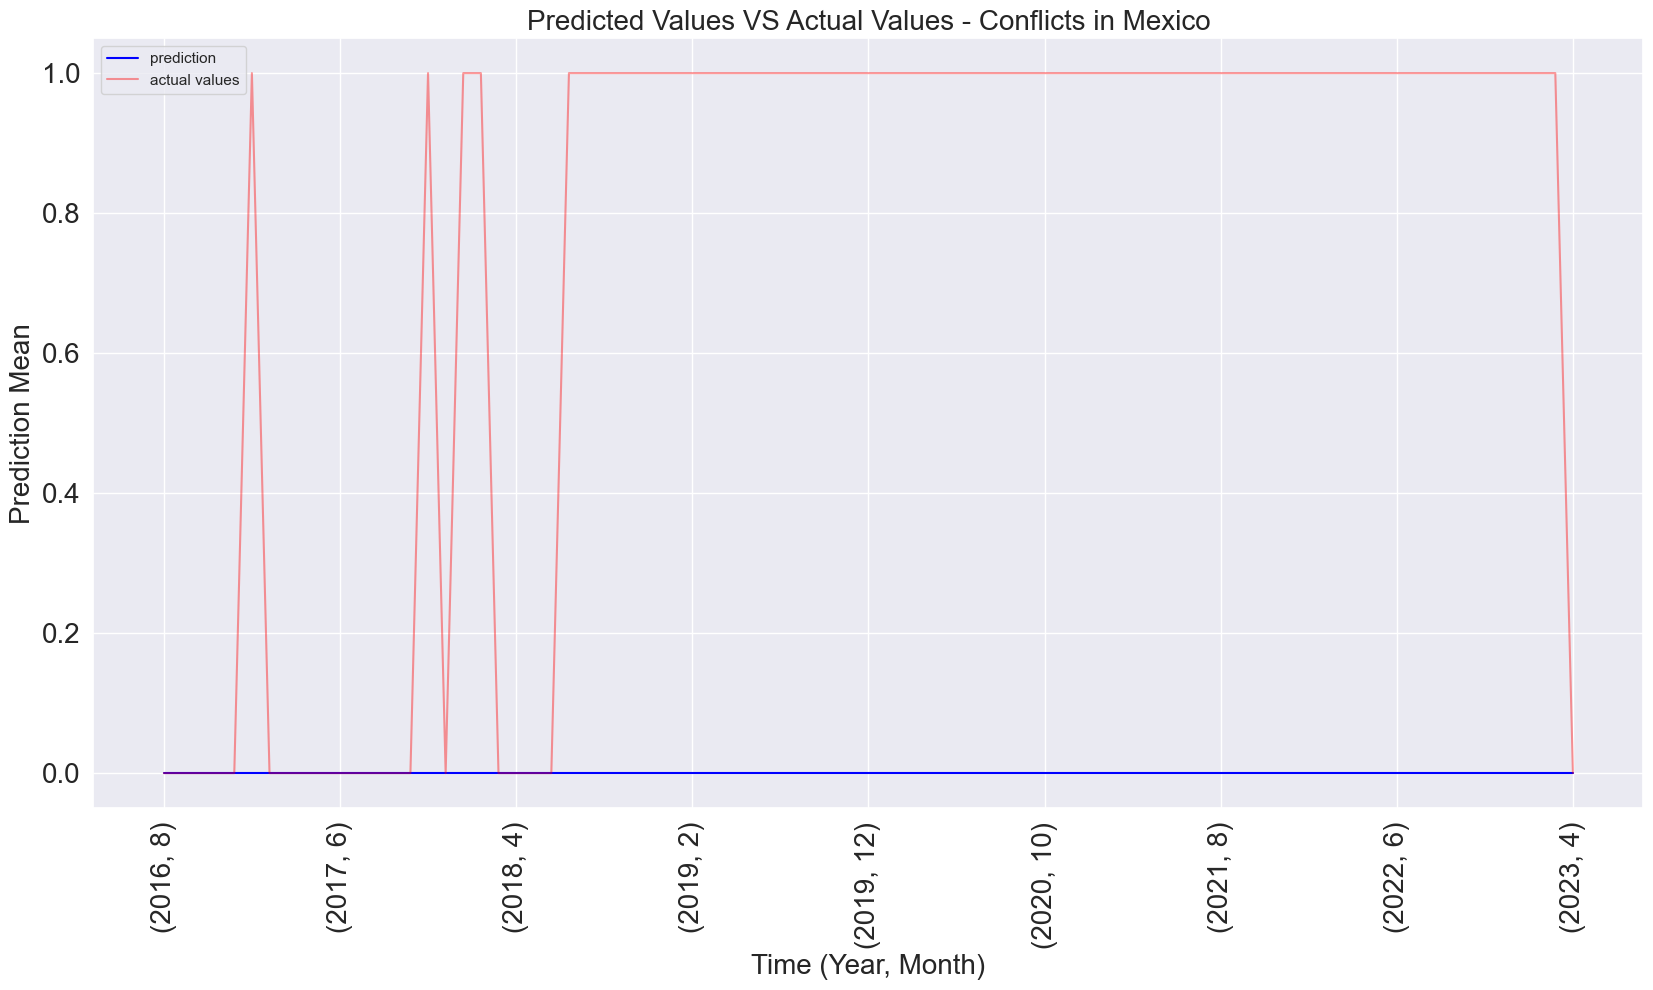

2023-06-19 15:06:39.592282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2023-06-19 15:06:43.811075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 59ms/step
Pakistan - RMSE: 0.19245008972987526


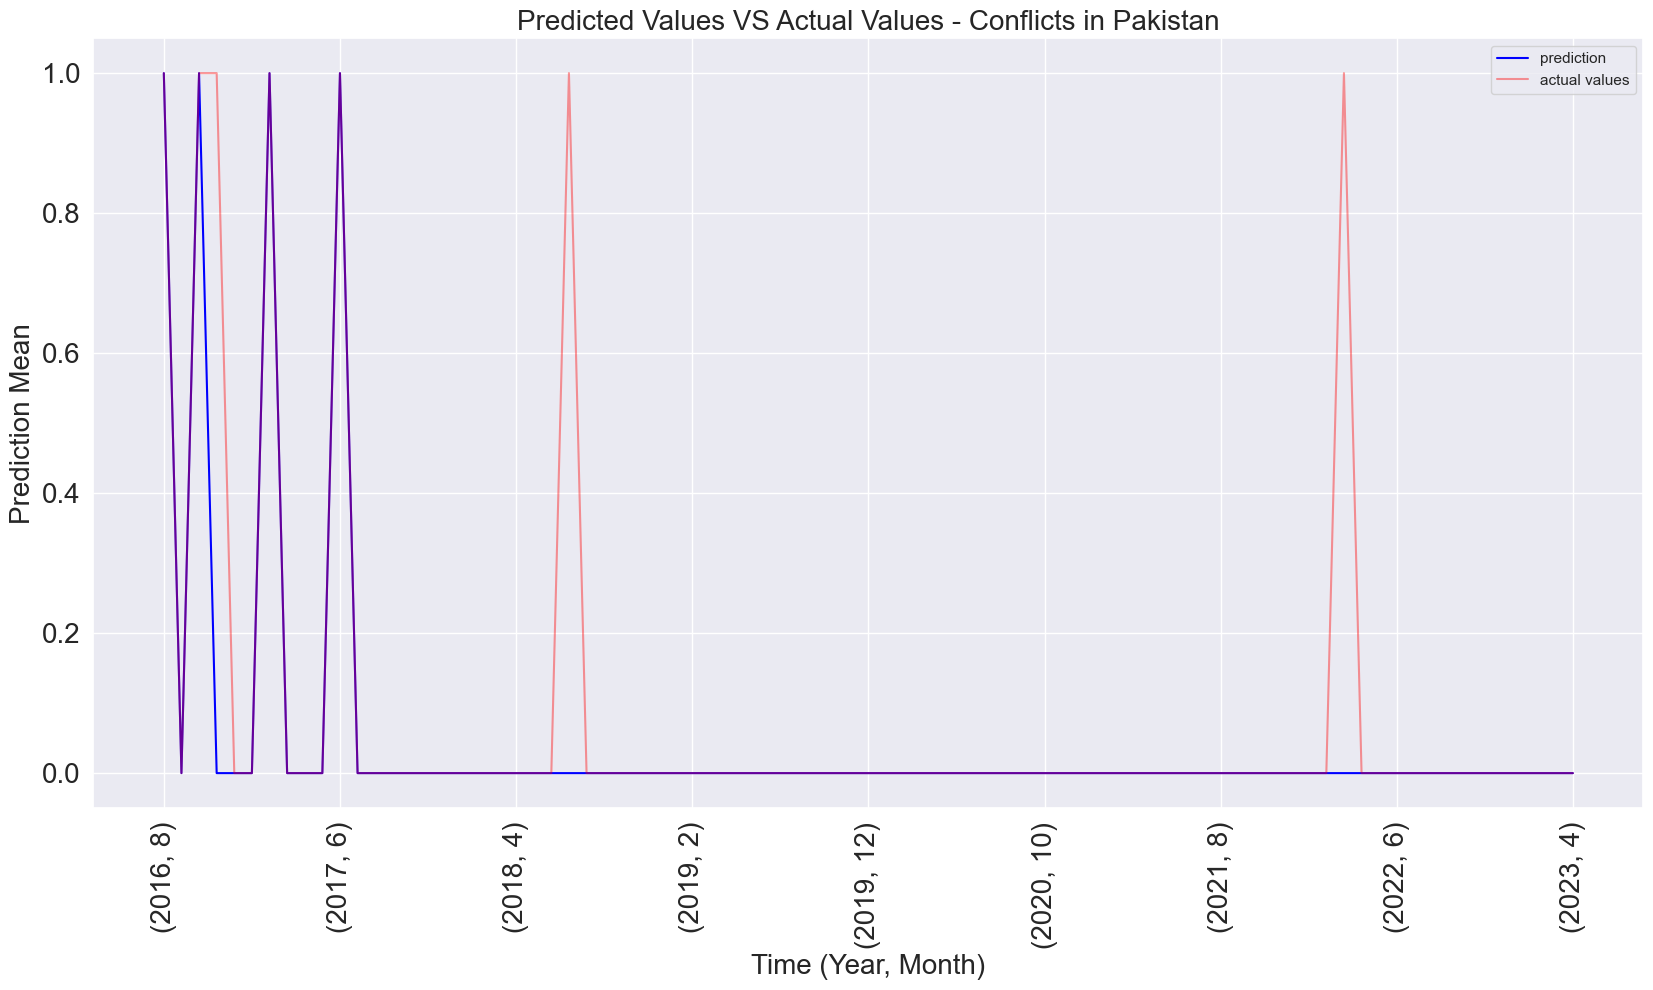

In [479]:
for i in range(len(top_10_country_names)): 
    # obtain one country's data 
    country = df_final[df_final.country == top_10_country_names[i]]
    # train test split, normalization and reshape the data
    x_train, x_test, y_train, y_test = normalization_train_test_split(country)
    # model 
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=0, shuffle=False)
    # make a prediction
    y_test_pre = model.predict(x_test)
    # convert to binary
    y_test_pre_binary = [1 if prob >= 0.5 else 0 for prob in y_test_pre]
    # RMSE
    rmse = RMSE(y_test[:-1], y_test_pre_binary[1:])
    print('{} - RMSE: {}'.format(top_10_country_names[i], rmse))
    # create new dataframe for plot 
    pa = pd.DataFrame()
    pa['Year'] = list(country.year.iloc[int(len(country)*0.8):])[1:-1]
    pa['Month'] = list(country.month.iloc[int(len(country)*0.8):])[1:-1]
    pa['Prediction'] = y_test_pre_binary[1:]
    pa['Actual Values'] = list(y_test[:-1])

    plt.figure(figsize=(20,10))
    pa.groupby(['Year', 'Month'])['Prediction'].mean().plot(kind='line', label='prediction', color='blue', alpha=1)
    pa.groupby(['Year', 'Month'])['Actual Values'].mean().plot(kind='line', label='actual values', color='red', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Prediction Mean', fontsize=20)
    plt.xlabel('Time (Year, Month)', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Conflicts in {}'.format(top_10_country_names[i]), fontsize=20)
    plt.legend()
    plt.show()
